creating day night image pairs

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
stereo_training_file_path = '/hdd1/madhu/data/robotcar/2014-12-16-18-44-24/files/train_1m.txt'
test_file_path = '/home/madhu/code/feature-slam/git_repos/dtd/datasets/robotcar/2014-12-16-18-44-24_test.txt'

In [3]:
train_files = np.loadtxt(stereo_training_file_path, dtype=int)
test_files = np.loadtxt(test_file_path, dtype=int)

unique_train_files = np.unique(train_files)
test_files = test_files[:,0]

print('train_files.shape', unique_train_files.shape)
print('test_files.shape', test_files.shape)

train_files.shape (21228,)
test_files.shape (716,)


In [4]:
intersection = set(unique_train_files).intersection(set(test_files))
print('intersection', len(intersection))

intersection 0


In [5]:
import numpy as np
from math import radians, cos, sin, asin, sqrt
from scipy.spatial.distance import cdist

import os, sys

import argparse


def readImgTS(path):
    imgTs = np.loadtxt(path,float,delimiter=' ',usecols=[0])
    return imgTs


def loadPoses(path):

    poseData = np.loadtxt(path,float,delimiter=',',skiprows=1,usecols=[0,1,2])

    return poseData[:,0], poseData[:,1:]


def getClosestPoseTsIndsPerImgTs(poseTs,imgTs):

    start_ind = 0
    paired_img_inds = []
    poseTs = poseTs.reshape(-1,1)
    imgTs = imgTs.reshape(-1,1)
    # for i_timestamp in imgTs:
    #     diff_mat = cdist([i_timestamp],poseTs[start_ind:start_ind+20].reshape([-1,1]))
    #     p_stamps.anp.argmin(diff_mat)
    #     sys.exit()

    diffMat = cdist(poseTs.reshape([-1,1]),imgTs.reshape([-1,1]))
    return np.argmin(diffMat,axis=0)

def getImgPoses(posPath,imPath):
    poseTS1, poseLatLon1 = loadPoses(posPath)
    imgTS1 = readImgTS(imPath)
    imgTS1 /=1e9
    poseTS1 /= 1e9
    closeInds = getClosestPoseTsIndsPerImgTs(poseTS1,imgTS1)
    imgPoses1 = poseLatLon1[closeInds,:]
    return imgPoses1,imgTS1*1e9

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 0.88915547 # this last factor has been calculated using 1-stereo from Google Maps

def haversineArr(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = [np.array(list(map(radians,arr))) for arr in [lon1, lat1, lon2, lat2]]

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r #*0.88915547 # this last factor has been calculated using 1-stereo from Google Maps

def cdist_haversine(ar2d_1,ar2d_2):
    """
    assumes ar2d as nx2 with lat lon as 1st and 2nd column
    """
    dists = []
    for i1 in range(len(ar2d_2)):
        val = haversineArr(ar2d_1[:,1],ar2d_1[:,0],ar2d_2[i1,1].reshape([1,-1]),ar2d_2[i1,0].reshape([1,-1]))
        dists.append(val)
    dists = np.array(dists)
    return dists.transpose()



In [14]:

night_poses = "/hdd1/madhu/data/robotcar/2014-12-16-18-44-24/gps/rtk.csv"
day_poses = "/hdd1/madhu/data/robotcar/2014-12-09-13-21-02/gps/rtk.csv"
day_timestamps = "/hdd1/madhu/data/robotcar/2014-12-09-13-21-02/stereo.timestamps"
night_timestamps = "/hdd1/madhu/data/robotcar/2014-12-16-18-44-24/stereo.timestamps"

In [7]:

imPoses1,img1_ts = getImgPoses(day_poses,day_timestamps)

In [15]:
imPoses2,img2_ts = getImgPoses(night_poses,night_timestamps)

In [17]:
dists_12 = cdist_haversine(imPoses1,imPoses2)

In [18]:
args=np.argmin(dists_12,axis=0)
timestamps=img1_ts[args]
print (np.array(img2_ts).shape)
print (np.array(timestamps).shape)
print(np.unique(timestamps).shape)


(32585,)
(32585,)
(12633,)


In [38]:
night_stamps = np.array(img2_ts)
day_stamps = np.array(timestamps)

#np.savetxt('paired_night_day.txt', np.stack([night_stamps, day_stamps], axis=1), fmt='%d')
paired_data = {}
for key,val in zip(night_stamps,day_stamps):
    paired_data[key] = val


In [44]:
stereo_training_file_path = '/hdd1/madhu/data/robotcar/2014-12-16-18-44-24/files/train_1m.txt'
train_stamps = np.unique(np.loadtxt(stereo_training_file_path, dtype = int))
train_paired_data =[]

for key in train_stamps:
    train_paired_data.append([key, paired_data[key]])
train_paired_data = np.array(train_paired_data)


In [102]:
train_paired_data = train_paired_data.astype(int)

paired_data = {}
for key,val in zip(train_paired_data[:,0],train_paired_data[:,1]):
    if val in (paired_data.values()):
        continue
    else:
        paired_data[key] = val
unique_paired_data = []
for key,val in paired_data.items():
    unique_paired_data.append([key,val])
unique_paired_data = np.array(unique_paired_data)

np.savetxt('unique_paired_night_day.txt', unique_paired_data, fmt='%d')


In [52]:
train_paired_data = train_paired_data.astype(int).astype(str)
np.savetxt('paired_night_day_train.txt', train_paired_data, fmt='%s')

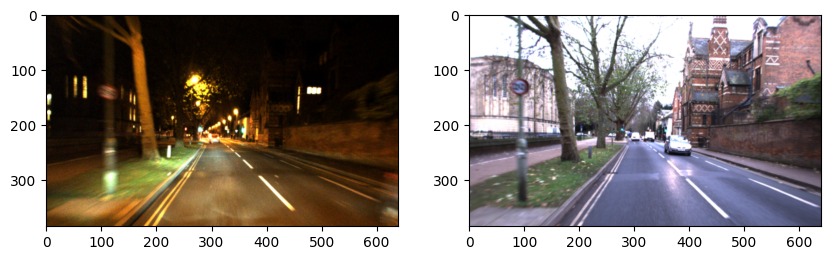

In [126]:
import cv2
randint = np.random.randint(0, len(unique_paired_data))
night_stamp, day_stamp = unique_paired_data[randint].astype(str)
night_path = '/hdd1/madhu/data/robotcar/2014-12-16-18-44-24/stereo/left_rgb/data/'
day_path = '/hdd1/madhu/data/robotcar/2014-12-09-13-21-02/stereo/left_rgb/data/'

day_image_path = os.path.join(day_path, day_stamp + '.png')
assert os.path.exists(day_image_path)
night_image_path = os.path.join(night_path, night_stamp + '.png')
assert os.path.exists(night_image_path)

night_image = cv2.imread(night_image_path)
day_image = cv2.imread(day_image_path)
night_image = cv2.cvtColor(night_image, cv2.COLOR_BGR2RGB)
day_image = cv2.cvtColor(day_image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(night_image)
ax[1].imshow(day_image)
plt.show()
